<a href="https://colab.research.google.com/github/ykitaguchi77/Colab_Scripts/blob/master/GradCAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**GradCAM**
https://www.yurui-deep-learning.com/2021/02/08/grad-campytorch-google-colab/

In [7]:
! pip install pytorch-gradcam
import os
import PIL
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.models as models
from torchvision import transforms
from torchvision.utils import make_grid, save_image

from gradcam.utils import visualize_cam
from gradcam import GradCAM, GradCAMpp

device = 'cuda' if torch.cuda.is_available() else 'cpu'

     |████████████████████████████████| 6.0 MB 9.5 MB/s 
  Created wheel for pytorch-gradcam: filename=pytorch_gradcam-0.2.1-py3-none-any.whl size=5269 sha256=6a7ddf9e268f6ce5aefbfdb633eafe23a6c5937dc4b28d752d66699092a9cd08
  Stored in directory: /root/.cache/pip/wheels/06/e7/da/b13a71980c3a787414e5ff8e156701c561c6322636396d71cc
Successfully built pytorch-gradcam


In [1]:
! wget https://raw.githubusercontent.com/vickyliin/gradcam_plus_plus-pytorch/master/images/water-bird.JPEG


--2021-08-10 07:34:14--  https://raw.githubusercontent.com/vickyliin/gradcam_plus_plus-pytorch/master/images/water-bird.JPEG
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 135167 (132K) [image/jpeg]
Saving to: ‘water-bird.JPEG’

water-bird.JPEG     100%[===================>] 132.00K  --.-KB/s    in 0.008s  

2021-08-10 07:34:14 (16.1 MB/s) - ‘water-bird.JPEG’ saved [135167/135167]



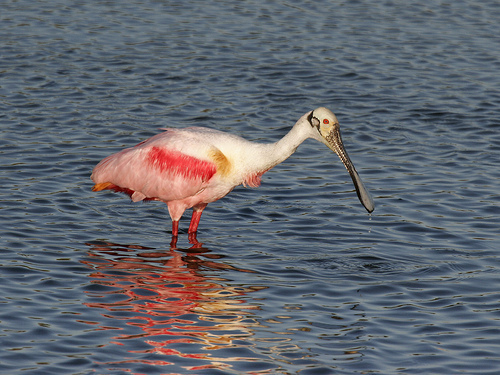

In [4]:
img_name = 'water-bird.JPEG'

pil_img = PIL.Image.open(img_name)
pil_img

In [8]:
torch_img = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])(pil_img).to(device)
normed_torch_img = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(torch_img)[None]

In [9]:
alexnet = models.alexnet(pretrained=True)
vgg = models.vgg16(pretrained=True)
resnet = models.resnet101(pretrained=True)
densenet = models.densenet161(pretrained=True)
squeezenet = models.squeezenet1_1(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth


Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-b8a52dc0.pth


In [11]:
configs = [
    dict(model_type='alexnet', arch=alexnet, layer_name='features_11'),
    dict(model_type='vgg', arch=vgg, layer_name='features_29'),
    dict(model_type='resnet', arch=resnet, layer_name='layer4'),
    dict(model_type='densenet', arch=densenet, layer_name='features_norm5'),
    dict(model_type='squeezenet', arch=squeezenet, layer_name='features_12_expand3x3_activation')
]

for config in configs:
    config['arch'].to(device).eval()

cams = [
    [cls.from_config(**config) for cls in (GradCAM, GradCAMpp)]
    for config in configs
]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  war

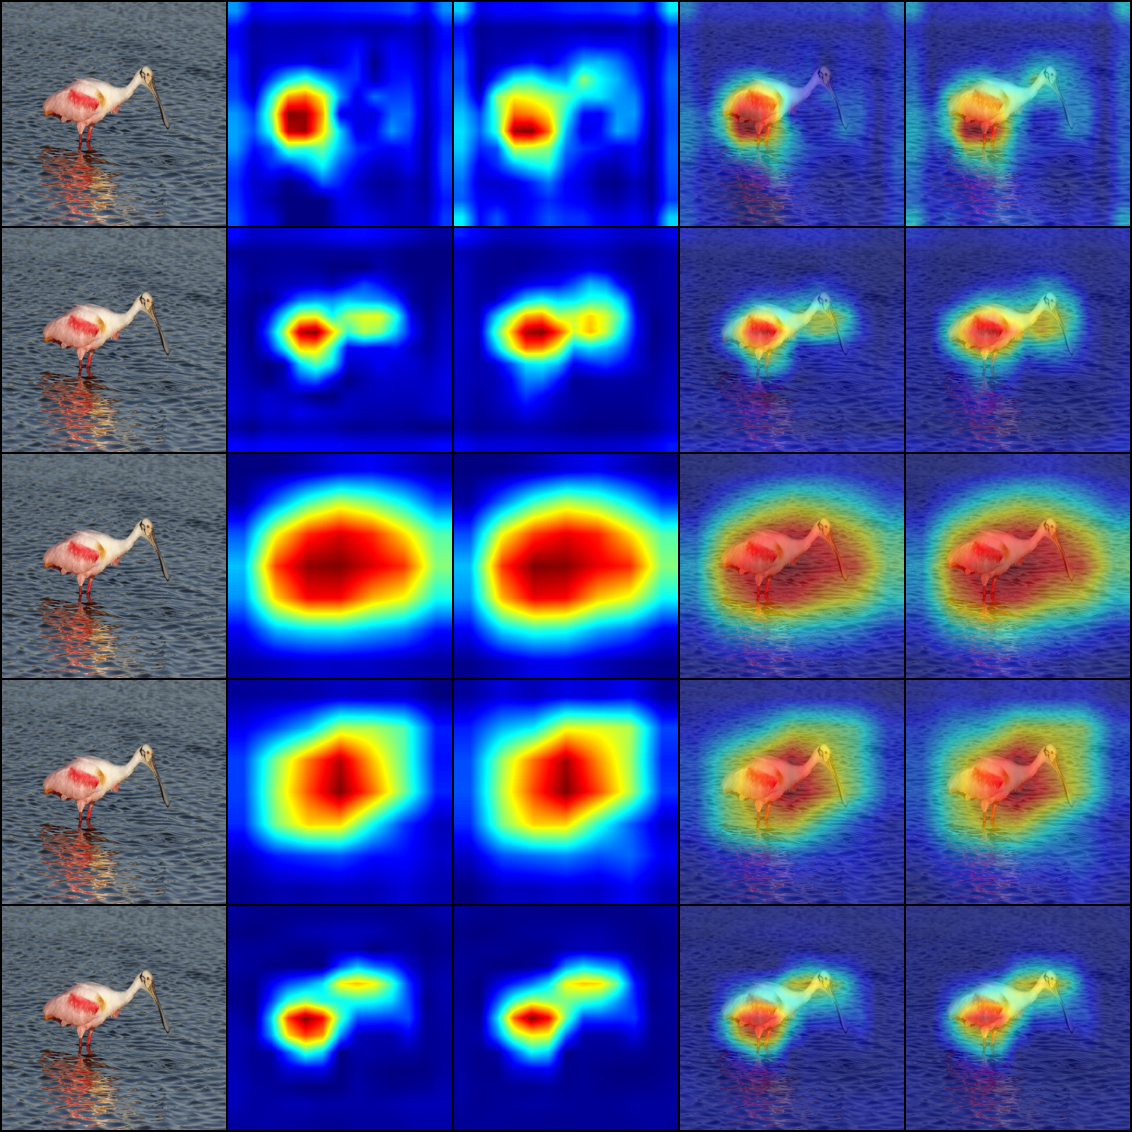

In [12]:
images = []
for gradcam, gradcam_pp in cams:
    mask, _ = gradcam(normed_torch_img)
    heatmap, result = visualize_cam(mask, torch_img)

    mask_pp, _ = gradcam_pp(normed_torch_img)
    heatmap_pp, result_pp = visualize_cam(mask_pp, torch_img)
    
    images.extend([torch_img.cpu(), heatmap, heatmap_pp, result, result_pp])
    
grid_image = make_grid(images, nrow=5)
transforms.ToPILImage()(grid_image)